In [1]:
# !pip install SimpleITK
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
from os.path import join

CT Shape=(189, 233, 197)
CT Mask Shape=(189, 233, 197)


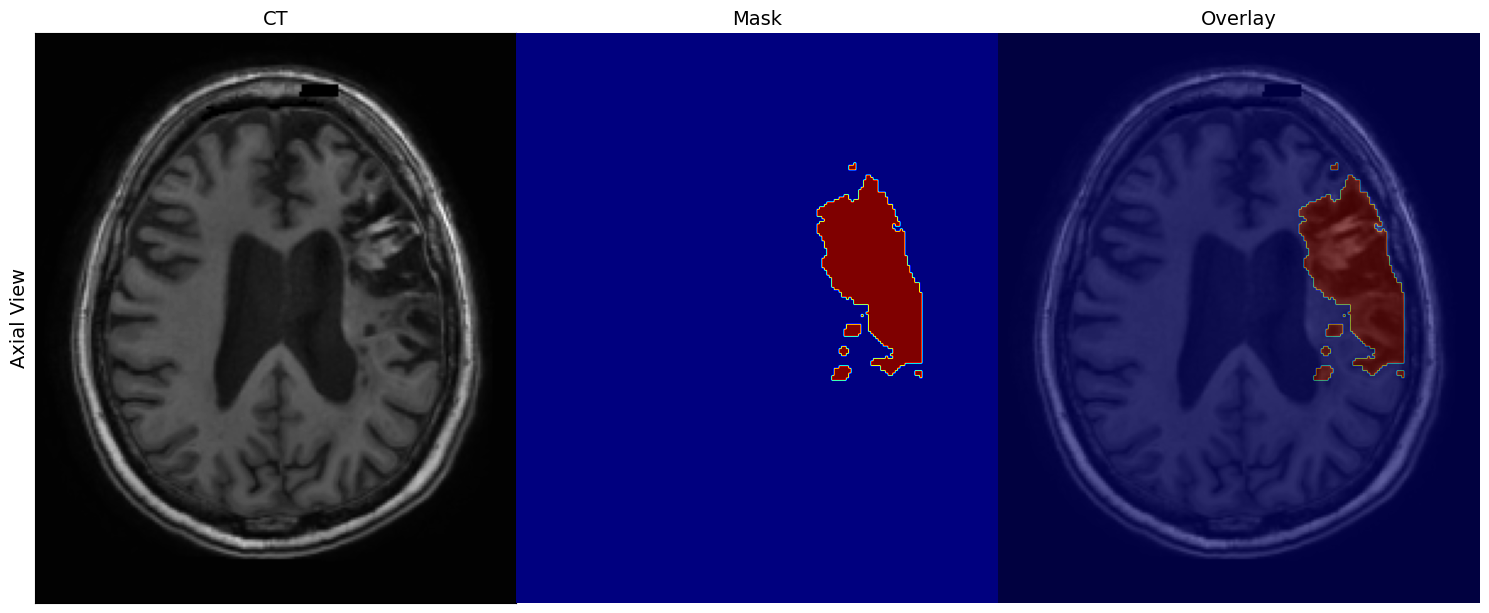

In [17]:
ct_label_path = "mask.nii.gz"

ct_path = "image.nii.gz"

# CT
img_sitk = sitk.ReadImage(ct_path, sitk.sitkFloat32)  # Reading CT
image = sitk.GetArrayFromImage(img_sitk)  # Converting sitk_metadata to image Array
# Mask
mask_sitk = sitk.ReadImage(ct_label_path, sitk.sitkInt32)  # Reading CT
mask = sitk.GetArrayFromImage(mask_sitk)  # Converting sitk_metada

print('CT Shape={}'.format(image.shape))
print('CT Mask Shape={}'.format(mask.shape))

# ----Lets plot
f, axarr = plt.subplots(1, 3, figsize=(15, 15))
axarr[0].imshow(np.squeeze(image[100, :, :]), cmap='gray', origin='lower')
axarr[0].set_ylabel('Axial View', fontsize=14)
axarr[0].set_xticks([])
axarr[0].set_yticks([])
axarr[0].set_title('CT', fontsize=14)

axarr[1].imshow(np.squeeze(mask[100, :, :]), cmap='jet', origin='lower')
axarr[1].axis('off')
axarr[1].set_title('Mask', fontsize=14)

axarr[2].imshow(np.squeeze(image[100, :, :]), cmap='gray', alpha=1, origin='lower')
axarr[2].imshow(np.squeeze(mask[100, :, :]), cmap='jet', alpha=0.5, origin='lower')
axarr[2].axis('off')
axarr[2].set_title('Overlay', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


In [18]:
def normalise(image):
    # normalise and clip images -1000 to 800
    np_img = image
    np_img = np.clip(np_img, -1000., 800.).astype(np.float32)
    return np_img


def whitening(image):
    """Whitening. Normalises image to zero mean and unit variance."""

    image = image.astype(np.float32)

    mean = np.mean(image)
    std = np.std(image)

    if std > 0:
        ret = (image - mean) / std
    else:
        ret = image * 0.
    return ret


def normalise_zero_one(image):
    """Image normalisation. Normalises image to fit [0, 1] range."""

    image = image.astype(np.float32)

    minimum = np.min(image)
    maximum = np.max(image)

    if maximum > minimum:
        ret = (image - minimum) / (maximum - minimum)
    else:
        ret = image * 0.
    return ret


def normalise_one_one(image):
    """Image normalisation. Normalises image to fit [-1, 1] range."""

    ret = normalise_zero_one(image)
    ret *= 2.
    ret -= 1.
    return ret

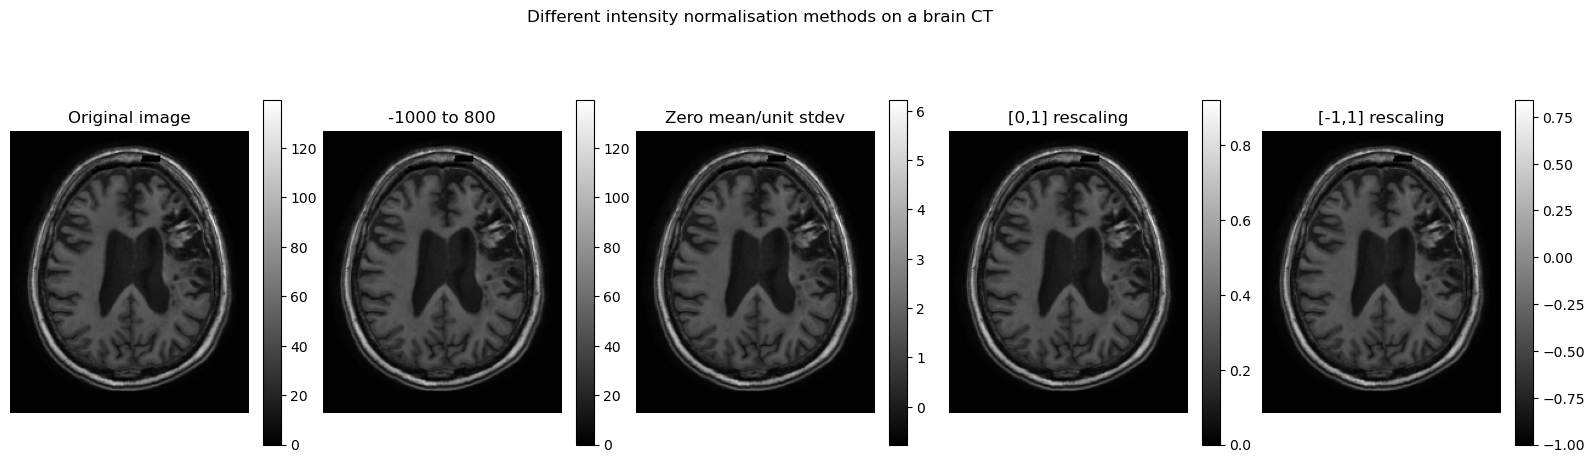

In [19]:
Normalize_minun100_to_800hu=normalise(image)
Normalize_0mean_UnitVr=whitening(image)
Normalize_0to1=normalise_zero_one(image)
normalise_minus1_to1=normalise_one_one(image)
f, axarr = plt.subplots(1, 5, figsize=(20,5));
f.suptitle('Different intensity normalisation methods on a brain CT')

img = axarr[0].imshow(np.squeeze(image[100, :, :]), cmap='gray',origin='lower');
axarr[0].axis('off')
axarr[0].set_title('Original image')
f.colorbar(img, ax=axarr[0])

img = axarr[1].imshow(np.squeeze(Normalize_minun100_to_800hu[100, :, :]), cmap='gray',origin='lower');
axarr[1].axis('off')
axarr[1].set_title('-1000 to 800')
f.colorbar(img, ax=axarr[1])

img = axarr[2].imshow(np.squeeze(Normalize_0mean_UnitVr[100, :, :]), cmap='gray',origin='lower');
axarr[2].axis('off')
axarr[2].set_title('Zero mean/unit stdev')
f.colorbar(img, ax=axarr[2])

img = axarr[3].imshow(np.squeeze(Normalize_0to1[100, :, :]), cmap='gray',origin='lower');
axarr[3].axis('off')
axarr[3].set_title('[0,1] rescaling')
f.colorbar(img, ax=axarr[3])

img = axarr[4].imshow(np.squeeze(normalise_minus1_to1[100, :, :]), cmap='gray',origin='lower');
axarr[4].axis('off')
axarr[4].set_title('[-1,1] rescaling')
f.colorbar(img, ax=axarr[4])
    
f.subplots_adjust(wspace=0.05, hspace=0, top=0.8)
plt.show();

CT Shape Original=(189, 233, 197), Resampled to 1mm=(189, 233, 197)
CT Mask Shape=(189, 233, 197), Resampled to 1mm=(189, 233, 197)


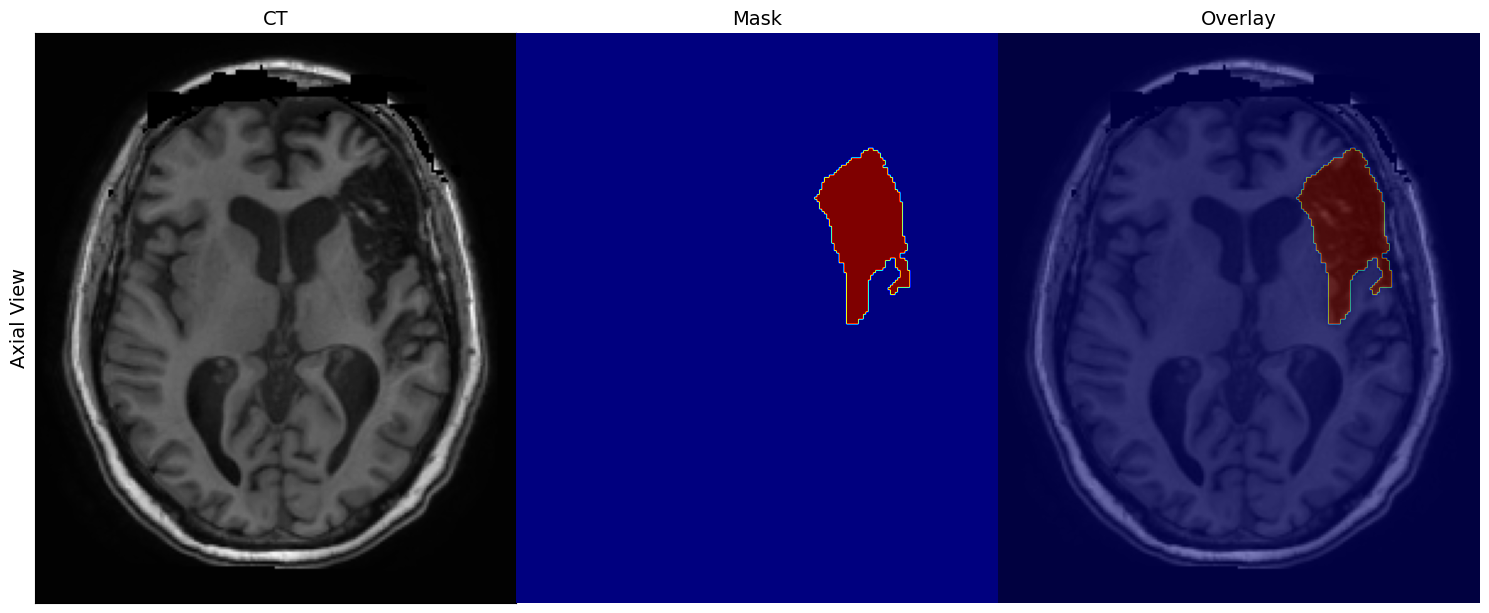

In [20]:
def resample_img(itk_image, out_spacing=[2.0, 2.0, 2.0], is_label=False):
    # resample images to 2mm spacing with simple itk

    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)


ct_resampled_to1m=resample_img(img_sitk, out_spacing=[1, 1, 1], is_label=False)
ct_resampled_to1m=sitk.GetArrayFromImage(ct_resampled_to1m)
mask_resampled_to1m=resample_img(mask_sitk, out_spacing=[1, 1, 1], is_label=True)
mask_resampled_to1m=sitk.GetArrayFromImage(mask_resampled_to1m)
print('CT Shape Original={}, Resampled to 1mm={}'.format(image.shape,ct_resampled_to1m.shape))
print('CT Mask Shape={}, Resampled to 1mm={}'.format(mask.shape,mask_resampled_to1m.shape))

#----Lets plot 
f, axarr = plt.subplots(1,3,figsize=(15,15))
SLICE = 74
axarr[0].imshow(np.squeeze(ct_resampled_to1m[SLICE, :, :]), cmap='gray',origin='lower');
axarr[0].set_ylabel('Axial View',fontsize=14)
axarr[0].set_xticks([])
axarr[0].set_yticks([])
axarr[0].set_title('CT',fontsize=14)

axarr[1].imshow(np.squeeze(mask_resampled_to1m[SLICE, :, :]), cmap='jet',origin='lower');
axarr[1].axis('off')
axarr[1].set_title('Mask',fontsize=14)

axarr[2].imshow(np.squeeze(ct_resampled_to1m[SLICE, :, :]), cmap='gray',alpha=1,origin='lower');
axarr[2].imshow(np.squeeze(mask_resampled_to1m[SLICE, :, :]),cmap='jet',alpha=0.5,origin='lower');
axarr[2].axis('off')
axarr[2].set_title('Overlay',fontsize=14)
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

In [21]:
from ipywidgets import interact, IntSlider

# Function to display slice with sliders for X, Y, and Z dimensions
def display_slices(x_idx):
    fig, axarr = plt.subplots(1, 3, figsize=(15, 15))

    SLICE = x_idx
    axarr[0].imshow(np.squeeze(ct_resampled_to1m[SLICE, :, :]), cmap='gray',origin='lower');
    axarr[0].set_ylabel('Axial View',fontsize=14)
    axarr[0].set_xticks([])
    axarr[0].set_yticks([])
    axarr[0].set_title('CT',fontsize=14)

    axarr[1].imshow(np.squeeze(mask_resampled_to1m[SLICE, :, :]), cmap='jet',origin='lower');
    axarr[1].axis('off')
    axarr[1].set_title('Mask',fontsize=14)

    axarr[2].imshow(np.squeeze(ct_resampled_to1m[SLICE, :, :]), cmap='gray',alpha=1,origin='lower');
    axarr[2].imshow(np.squeeze(mask_resampled_to1m[SLICE, :, :]),cmap='jet',alpha=0.5,origin='lower');
    axarr[2].axis('off')
    axarr[2].set_title('Overlay',fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)

# Determine the number of slices along each dimension
num_slices_z = ct_resampled_to1m.shape[0]

# Create sliders for X, Y, and Z dimensions

slider_x = IntSlider(min=0, max=num_slices_z-1, step=1, value=num_slices_z//2)

# Display interactive plot with sliders
interact(display_slices, x_idx=slider_x)

interactive(children=(IntSlider(value=94, description='x_idx', max=188), Output()), _dom_classes=('widget-inte…

<function __main__.display_slices(x_idx)>